In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add src to path
sys.path.append('../src')

# Import modules
from data_loader import MRIDataLoader
from pca_analysis import PCAAnalyzer
from segmentation import TissueSegmenter, compare_segmentations
from visualization import *
from utils import create_synthetic_mri_data, compute_tissue_statistics
from main import SegmentationPipeline

# Reload brats_loader to get latest changes
import importlib
if 'brats_loader' in sys.modules:
    importlib.reload(sys.modules['brats_loader'])
from brats_loader import BraTSLoader

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

ModuleNotFoundError: No module named 'numpy'

## 1. Load and Visualize BraTS2020 Data

Load brain tumor MRI data from the BraTS2020 dataset. The dataset contains multi-modal MRI sequences (T1, T1ce, T2, FLAIR) and ground truth tumor segmentations.

**Note**: If you don't have the BraTS2020 data yet, the code will use synthetic data for demonstration.

INFO:brats_loader:Found 369 subjects
INFO:data_loader:Loaded ..\data\raw\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii with shape (240, 240, 155)
INFO:data_loader:Loaded ..\data\raw\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii with shape (240, 240, 155)
INFO:data_loader:Loaded ..\data\raw\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii with shape (240, 240, 155)
INFO:data_loader:Loaded ..\data\raw\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii with shape (240, 240, 155)


Loading BraTS2020 dataset...
Loading subject: BraTS20_Training_001


INFO:data_loader:Loaded ..\data\raw\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t2.nii with shape (240, 240, 155)
INFO:data_loader:Loaded ..\data\raw\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii with shape (240, 240, 155)
INFO:data_loader:Loaded ..\data\raw\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii with shape (240, 240, 155)
INFO:data_loader:Loaded ..\data\raw\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_seg.nii with shape (240, 240, 155)
INFO:brats_loader:Loaded subject BraTS20_Training_001 with 5 volumes
INFO:brats_loader:Selected slice 67 with 5048 tumor pixels
INFO:data_loader:Loaded ..\data\raw\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_seg.nii with shape (240, 240, 155)
INFO:brats_loader:Loaded subject BraTS2

Selected slice 67 (axial)


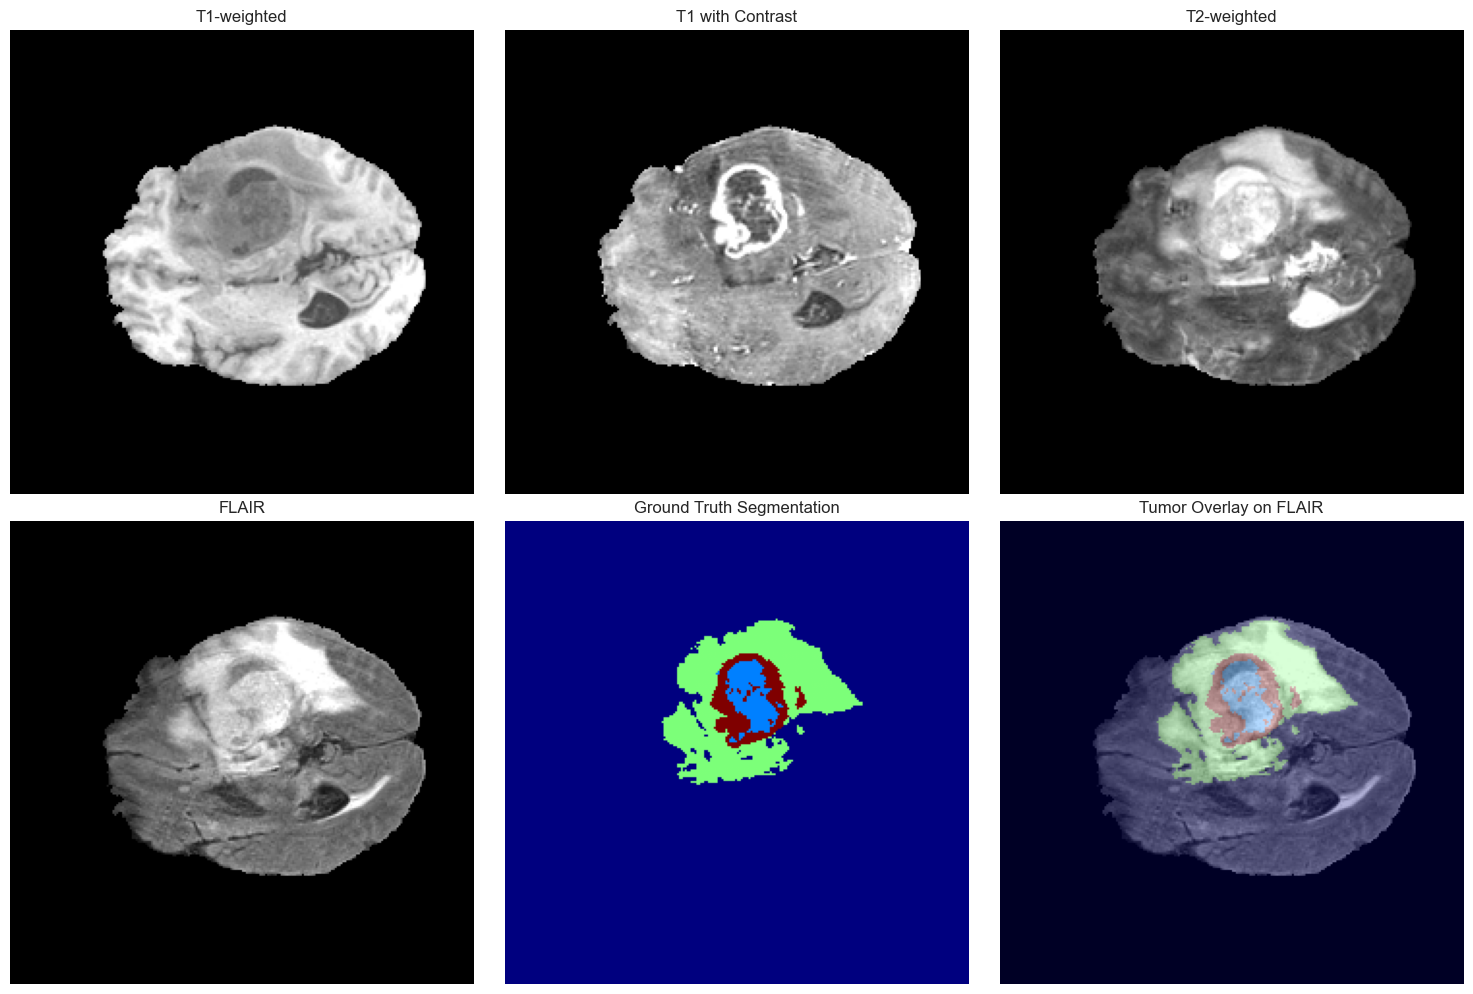


Image shape: (240, 240)
Intensity range: [0.000, 1.000]
Tumor labels present: [0. 1. 2. 4.]


In [ ]:
# Try to load BraTS2020 data
USE_BRATS = True  # Set to False to use synthetic data
BRATS_DATA_PATH = '../data/raw/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

if USE_BRATS and Path(BRATS_DATA_PATH).exists():
    print("Loading BraTS2020 dataset...")
    
    # Initialize BraTS loader
    brats_loader = BraTSLoader(BRATS_DATA_PATH)
    
    # Get list of subjects
    subjects = brats_loader.get_subject_list()
    
    if subjects:
        # Load first subject with tumor
        subject_id = subjects[0]
        print(f"Loading subject: {subject_id}")
        
        slices, slice_idx = brats_loader.load_subject_with_tumor_slice(subject_id, axis=2)
        print(f"Selected slice {slice_idx} (axial)")
        
        # Get modalities for analysis
        t1_slice = slices['t1']
        t2_slice = slices['t2']
        flair_slice = slices['flair']
        ground_truth = slices.get('seg', None)
        
        # Use FLAIR as main image (good for tumor visualization)
        image = flair_slice
        
        # Visualize all modalities
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        axes[0, 0].imshow(slices['t1'], cmap='gray')
        axes[0, 0].set_title('T1-weighted')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(slices.get('t1ce', slices['t1']), cmap='gray')
        axes[0, 1].set_title('T1 with Contrast')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(slices['t2'], cmap='gray')
        axes[0, 2].set_title('T2-weighted')
        axes[0, 2].axis('off')
        
        axes[1, 0].imshow(slices['flair'], cmap='gray')
        axes[1, 0].set_title('FLAIR')
        axes[1, 0].axis('off')
        
        if ground_truth is not None:
            axes[1, 1].imshow(ground_truth, cmap='jet', vmin=0, vmax=4)
            axes[1, 1].set_title('Ground Truth Segmentation')
            axes[1, 1].axis('off')
            
            # Show tumor overlay on FLAIR
            overlay = flair_slice.copy()
            axes[1, 2].imshow(overlay, cmap='gray')
            axes[1, 2].imshow(ground_truth, cmap='jet', alpha=0.3, vmin=0, vmax=4)
            axes[1, 2].set_title('Tumor Overlay on FLAIR')
            axes[1, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nImage shape: {image.shape}")
        print(f"Intensity range: [{image.min():.3f}, {image.max():.3f}]")
        if ground_truth is not None:
            unique_labels = np.unique(ground_truth)
            print(f"Tumor labels present: {unique_labels}")
    else:
        print("No subjects found in BraTS directory. Using synthetic data.")
        USE_BRATS = False
else:
    print("BraTS2020 data not found. Using synthetic data for demonstration.")
    USE_BRATS = False

# Fallback to synthetic data
if not USE_BRATS:
    print("\nCreating synthetic brain tumor data...")
    image, ground_truth = create_synthetic_mri_data(shape=(256, 256), n_tissues=3, noise_level=0.1)
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Synthetic MRI Image')
    ax1.axis('off')
    
    ax2.imshow(ground_truth, cmap='viridis')
    ax2.set_title('Ground Truth')
    ax2.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Image shape: {image.shape}")
    print(f"Intensity range: [{image.min():.3f}, {image.max():.3f}]")

## 2. Mathematical Formulation: Eigenanalysis for Brain Tumor Segmentation

### Theory

Given multi-modal MRI image pixels represented as vectors $\mathbf{x}_i \in \mathbb{R}^p$ for $i = 1, \ldots, n$:

1. **Stack samples**: $\mathbf{X} \in \mathbb{R}^{n \times p}$ where each row is a pixel and columns are features from different MRI modalities
2. **Center data**: $\mathbf{X}_{centered} = \mathbf{X} - \bar{\mathbf{X}}$
3. **Covariance matrix**: $\mathbf{C} = \frac{1}{n-1} \mathbf{X}^T \mathbf{X}$
4. **Eigendecomposition**: $\mathbf{C}\mathbf{v}_j = \lambda_j \mathbf{v}_j$ for the jth eigenvector and eigenvalue
5. **Project data**: $\mathbf{Y} = \mathbf{X} \mathbf{V}_k$ where $\mathbf{V}_k$ contains $k$ eigenvectors with largest eigenvalues
6. **Cluster in PC space** to segment tumor regions, edema, and healthy tissue

### Application to BraTS2020
- **Multi-modal features**: Combine T1, T2, FLAIR intensities for each pixel
- **Dimensionality reduction**: PCA reduces from 3-4 modalities to k principal components
- **Clustering**: GMM identifies tumor subregions in the reduced eigenspace

## 3. Run Complete Segmentation Pipeline

Run PCA-based segmentation on the brain tumor data.

In [ ]:
# Prepare multi-modal data if using BraTS2020
if USE_BRATS and 't2_slice' in locals():
    print("Preparing multi-modal data matrix...")
    
    # Stack modalities as features
    modalities_to_use = ['t1', 't2', 'flair']
    available_slices = {k: v for k, v in slices.items() if k in modalities_to_use}
    
    print(f"Using modalities: {list(available_slices.keys())}")
    
    # For single-channel analysis, we'll still use FLAIR as main image
    # But we can reference the multi-modal data for comparison
    multimodal_available = True
else:
    multimodal_available = False
    print("Using single-channel data")

Preparing multi-modal data matrix...
Using modalities: ['t1', 't2', 'flair']


## 2.5. Prepare Multi-Modal Data (BraTS2020)

If using BraTS2020 data, combine multiple MRI modalities for enhanced segmentation.

In [ ]:
# Initialize pipeline
# For brain tumors: typically 3-4 clusters (background, edema, tumor core, enhancing tumor)
n_components = 5  # Number of principal components
n_clusters = 4 if USE_BRATS else 3  # 4 for BraTS (background + 3 tumor regions), 3 for synthetic

pipeline = SegmentationPipeline(n_components=n_components, n_clusters=n_clusters)

# Run pipeline
print(f"Running segmentation pipeline with {n_clusters} clusters...")
results = pipeline.run_pipeline(image)

print("\n✓ Pipeline complete!")
print(f"Segmented into {n_clusters} regions")

INFO:main:============================================================
INFO:main:Starting segmentation pipeline
INFO:main:============================================================
INFO:main:Preprocessing image...
INFO:main:Data matrix shape: (57600, 1)
INFO:main:Performing PCA...
INFO:main:Creating multi-channel features from image patches...
INFO:main:Created 5 features per pixel
INFO:main:Starting segmentation pipeline
INFO:main:============================================================
INFO:main:Preprocessing image...
INFO:main:Data matrix shape: (57600, 1)
INFO:main:Performing PCA...
INFO:main:Creating multi-channel features from image patches...
INFO:main:Created 5 features per pixel
INFO:pca_analysis:Fitting PCA on data with shape (57600, 5)
INFO:pca_analysis:Top 5 components explain 100.00% of variance
INFO:pca_analysis:Transformed data to shape (57600, 5)
INFO:main:PCA transformed data shape: (57600, 5)
INFO:main:Performing tissue segmentation...
INFO:segmentation:Fitting 

Running segmentation pipeline with 4 clusters...


INFO:segmentation:Clustering complete. Label distribution: [38725  8648  4880  5347]
INFO:main:============================================================
INFO:main:Pipeline complete!
INFO:main:============================================================
INFO:main:============================================================
INFO:main:Pipeline complete!
INFO:main:============================================================



✓ Pipeline complete!
Segmented into 4 regions


## 4. Analyze Eigenvalues and Explained Variance

Saved figure to ../results/figures/explained_variance.png


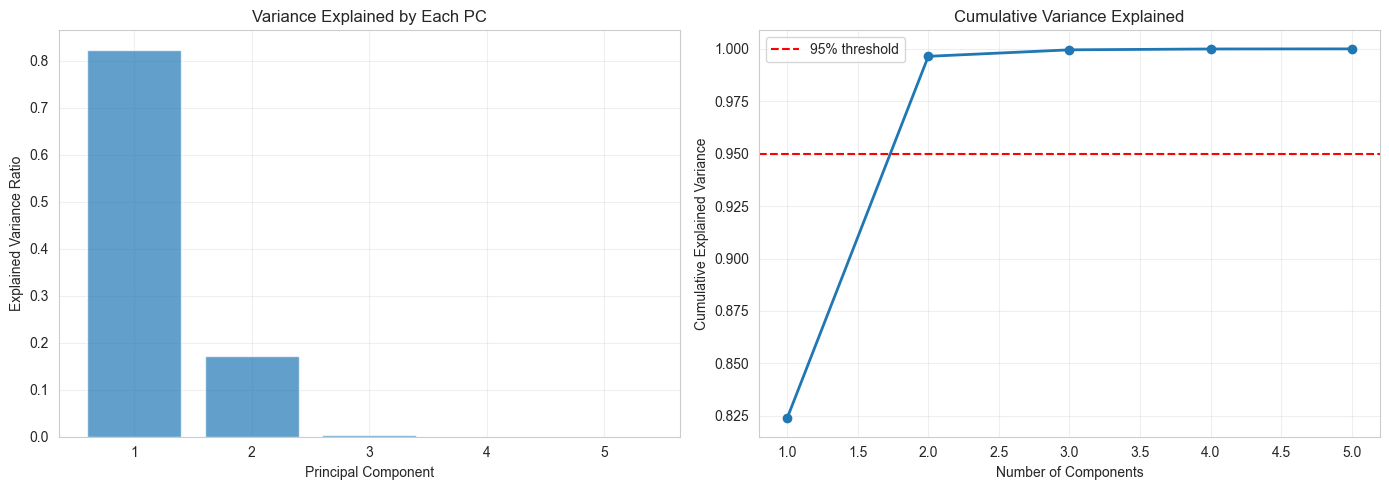


Variance Explained by Components:
PC 1: 0.8238 (cumulative: 0.8238)
PC 2: 0.1726 (cumulative: 0.9965)
PC 3: 0.0031 (cumulative: 0.9995)
PC 4: 0.0004 (cumulative: 1.0000)
PC 5: 0.0000 (cumulative: 1.0000)


In [ ]:
# Plot explained variance
plot_explained_variance(results['pca'], save_path='../results/figures/explained_variance.png')

# Print variance statistics
print("\nVariance Explained by Components:")
for i, (var_ratio, cum_var) in enumerate(zip(
    results['pca'].explained_variance_ratio_,
    results['pca'].get_cumulative_variance()
)):
    print(f"PC {i+1}: {var_ratio:.4f} (cumulative: {cum_var:.4f})")

## 5. Visualize Segmentation Results

Saved figure to ../results/figures/segmentation_pca.png


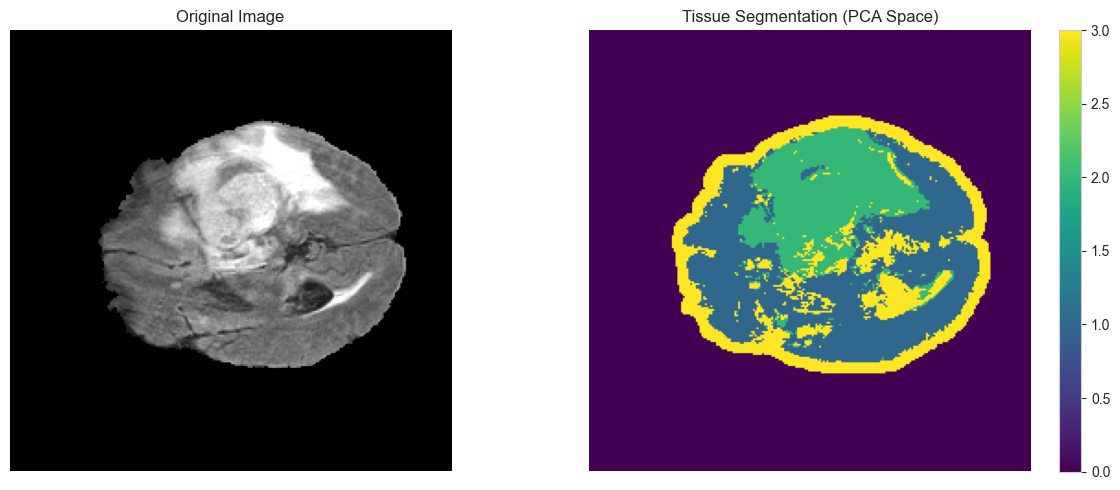

In [ ]:
# Plot segmentation
plot_segmentation(
    results['image'],
    results['segmentation'],
    title='Tissue Segmentation (PCA Space)',
    save_path='../results/figures/segmentation_pca.png'
)

## 6. Visualize Data in PC Space

Saved figure to ../results/figures/pca_projection.png


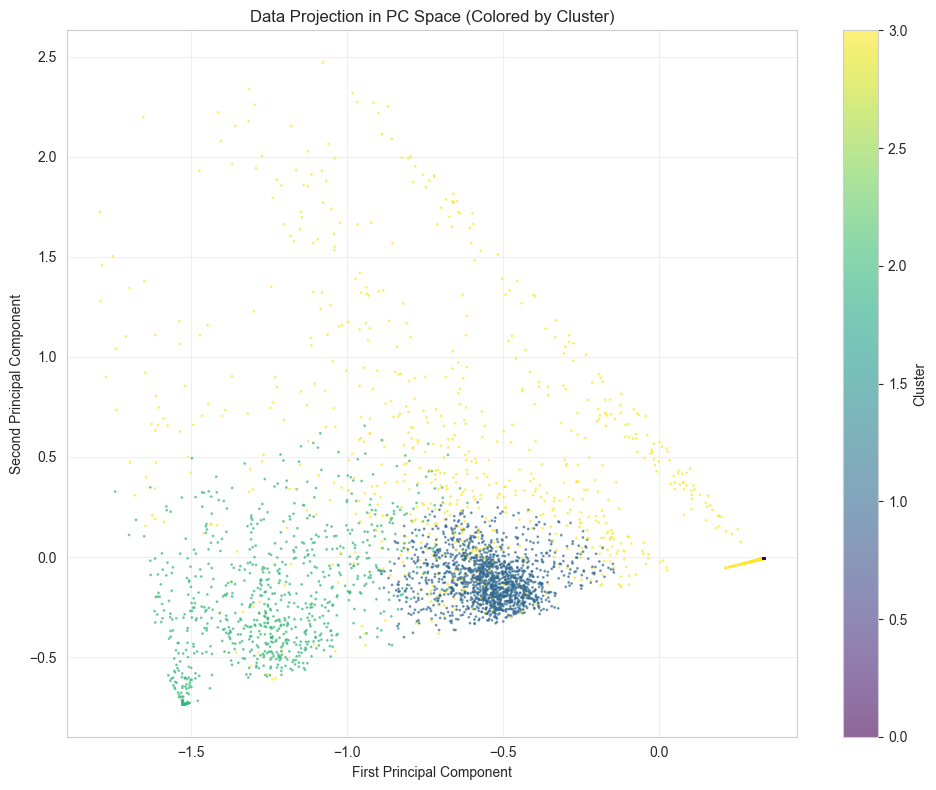

In [ ]:
# Sample points for visualization (full dataset may be too large)
n_samples = min(10000, len(results['Y_pca']))
idx_sample = np.random.choice(len(results['Y_pca']), n_samples, replace=False)

plot_pca_projection_2d(
    results['Y_pca'][idx_sample],
    results['labels'][idx_sample],
    save_path='../results/figures/pca_projection.png'
)

## 7. Compare with Original Space Segmentation

INFO:segmentation:Performing segmentation in original space
INFO:segmentation:Fitting GMM with 4 clusters
INFO:segmentation:Fitting GMM with 4 clusters


Performing segmentation in original space...


INFO:segmentation:Clustering complete. Label distribution: [38725  8648  4880  5347]


Saved figure to ../results/figures/comparison.png


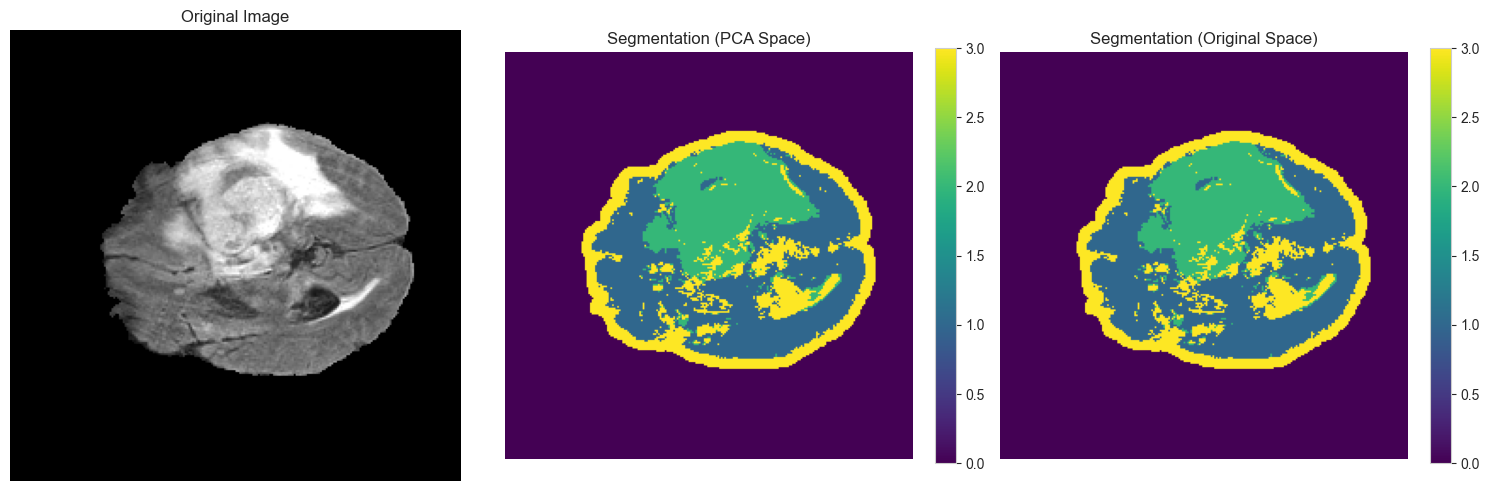

INFO:segmentation:ARI: 1.0000, NMI: 1.0000



Comparison Metrics:
adjusted_rand_index: 1.0000
normalized_mutual_info: 1.0000


In [ ]:
# Segment in original space for comparison
from segmentation import segment_with_original_space

print("Performing segmentation in original space...")
labels_original = segment_with_original_space(
    pipeline.X_original,
    n_clusters=n_clusters,
    method='gmm'
)
seg_original = labels_original.reshape(image.shape)

# Compare
plot_comparison(
    image,
    results['segmentation'],
    seg_original,
    save_path='../results/figures/comparison.png'
)

# Quantitative comparison
comparison_metrics = compare_segmentations(results['labels'], labels_original)
print("\nComparison Metrics:")
for metric, value in comparison_metrics.items():
    print(f"{metric}: {value:.4f}")

## 8. Tissue Statistics


Tissue Statistics:
          mean_intensity  std_intensity  median_intensity  voxel_count  percentage
tissue_0        0.000000       0.000000          0.000000      38725.0   67.230903
tissue_1        0.427188       0.071872          0.427397       8648.0   15.013889
tissue_2        0.766056       0.157684          0.780822       4880.0    8.472222
tissue_3        0.281971       0.255328          0.263014       5347.0    9.282986


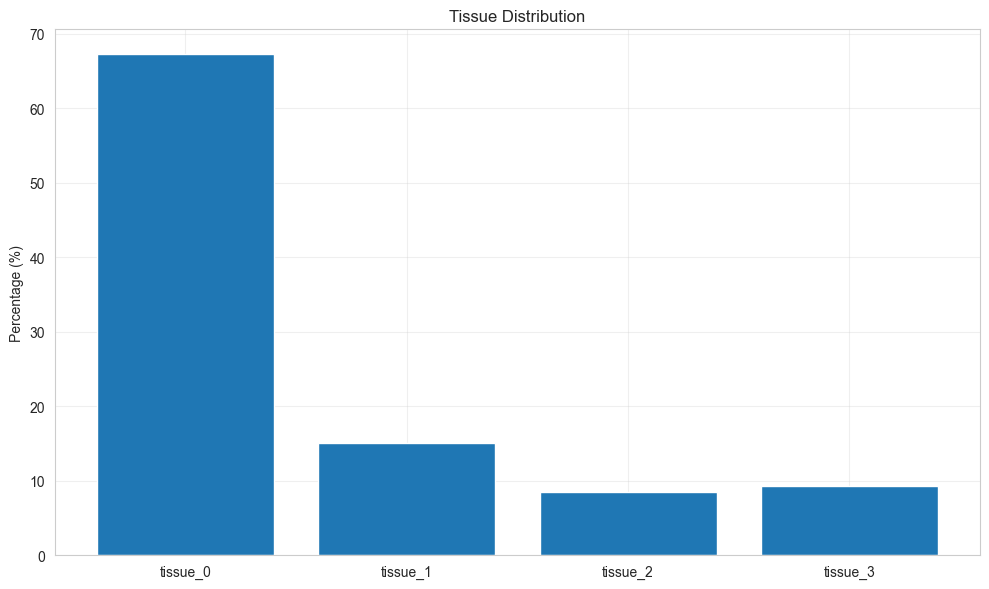

In [ ]:
# Display tissue statistics
import pandas as pd

stats_df = pd.DataFrame(results['statistics']).T
print("\nTissue Statistics:")
print(stats_df.to_string())

# Visualize tissue distribution
fig, ax = plt.subplots(figsize=(10, 6))
tissues = list(results['statistics'].keys())
percentages = [results['statistics'][t]['percentage'] for t in tissues]

ax.bar(tissues, percentages)
ax.set_ylabel('Percentage (%)')
ax.set_title('Tissue Distribution')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/tissue_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Explore Different Numbers of Components

INFO:main:============================================================
INFO:main:Starting segmentation pipeline
INFO:main:============================================================
INFO:main:Preprocessing image...
INFO:main:Data matrix shape: (57600, 1)
INFO:main:Performing PCA...
INFO:main:Creating multi-channel features from image patches...
INFO:main:Starting segmentation pipeline
INFO:main:============================================================
INFO:main:Preprocessing image...
INFO:main:Data matrix shape: (57600, 1)
INFO:main:Performing PCA...
INFO:main:Creating multi-channel features from image patches...
INFO:main:Created 5 features per pixel
INFO:pca_analysis:Fitting PCA on data with shape (57600, 5)
INFO:pca_analysis:Top 2 components explain 99.65% of variance
INFO:pca_analysis:Transformed data to shape (57600, 2)
INFO:main:PCA transformed data shape: (57600, 2)
INFO:main:Performing tissue segmentation...
INFO:segmentation:Fitting GMM with 4 clusters
INFO:main:Created 5 


Testing with 2 components...


INFO:segmentation:Clustering complete. Label distribution: [38842  9312  4509  4937]
INFO:main:============================================================
INFO:main:Pipeline complete!
INFO:main:============================================================
INFO:main:============================================================
INFO:main:Starting segmentation pipeline
INFO:main:============================================================
INFO:main:Preprocessing image...
INFO:main:Data matrix shape: (57600, 1)
INFO:main:============================================================
INFO:main:Pipeline complete!
INFO:main:============================================================
INFO:main:============================================================
INFO:main:Starting segmentation pipeline
INFO:main:============================================================
INFO:main:Preprocessing image...
INFO:main:Data matrix shape: (57600, 1)
INFO:main:Performing PCA...
INFO:main:Creating multi-channel 


Testing with 3 components...


INFO:segmentation:Clustering complete. Label distribution: [38767  9031  4980  4822]
INFO:main:============================================================
INFO:main:Pipeline complete!
INFO:main:============================================================
INFO:main:============================================================
INFO:main:Starting segmentation pipeline
INFO:main:============================================================
INFO:main:Preprocessing image...
INFO:main:Data matrix shape: (57600, 1)
INFO:main:Performing PCA...
INFO:main:Creating multi-channel features from image patches...
INFO:main:Created 5 features per pixel
INFO:main:============================================================
INFO:main:Pipeline complete!
INFO:main:============================================================
INFO:main:============================================================
INFO:main:Starting segmentation pipeline
INFO:main:============================================================
INF


Testing with 5 components...


INFO:segmentation:Clustering complete. Label distribution: [38725  8648  4880  5347]
INFO:main:============================================================
INFO:main:Pipeline complete!
INFO:main:============================================================
INFO:main:============================================================
INFO:main:Starting segmentation pipeline
INFO:main:============================================================
INFO:main:Preprocessing image...
INFO:main:Data matrix shape: (57600, 1)
INFO:main:Performing PCA...
INFO:main:Creating multi-channel features from image patches...
INFO:main:Created 5 features per pixel
INFO:main:============================================================
INFO:main:Pipeline complete!
INFO:main:============================================================
INFO:main:============================================================
INFO:main:Starting segmentation pipeline
INFO:main:============================================================
INF


Testing with 7 components...


INFO:segmentation:Clustering complete. Label distribution: [38725  8648  4880  5347]
INFO:main:============================================================
INFO:main:Pipeline complete!
INFO:main:============================================================
INFO:main:============================================================
INFO:main:Starting segmentation pipeline
INFO:main:============================================================
INFO:main:Preprocessing image...
INFO:main:Data matrix shape: (57600, 1)
INFO:main:Performing PCA...
INFO:main:============================================================
INFO:main:Pipeline complete!
INFO:main:============================================================
INFO:main:============================================================
INFO:main:Starting segmentation pipeline
INFO:main:============================================================
INFO:main:Preprocessing image...
INFO:main:Data matrix shape: (57600, 1)
INFO:main:Performing PCA...
INFO:


Testing with 10 components...


INFO:segmentation:Clustering complete. Label distribution: [38725  8648  4880  5347]
INFO:main:============================================================
INFO:main:Pipeline complete!
INFO:main:============================================================
INFO:main:Pipeline complete!
INFO:main:============================================================
INFO:main:============================================================


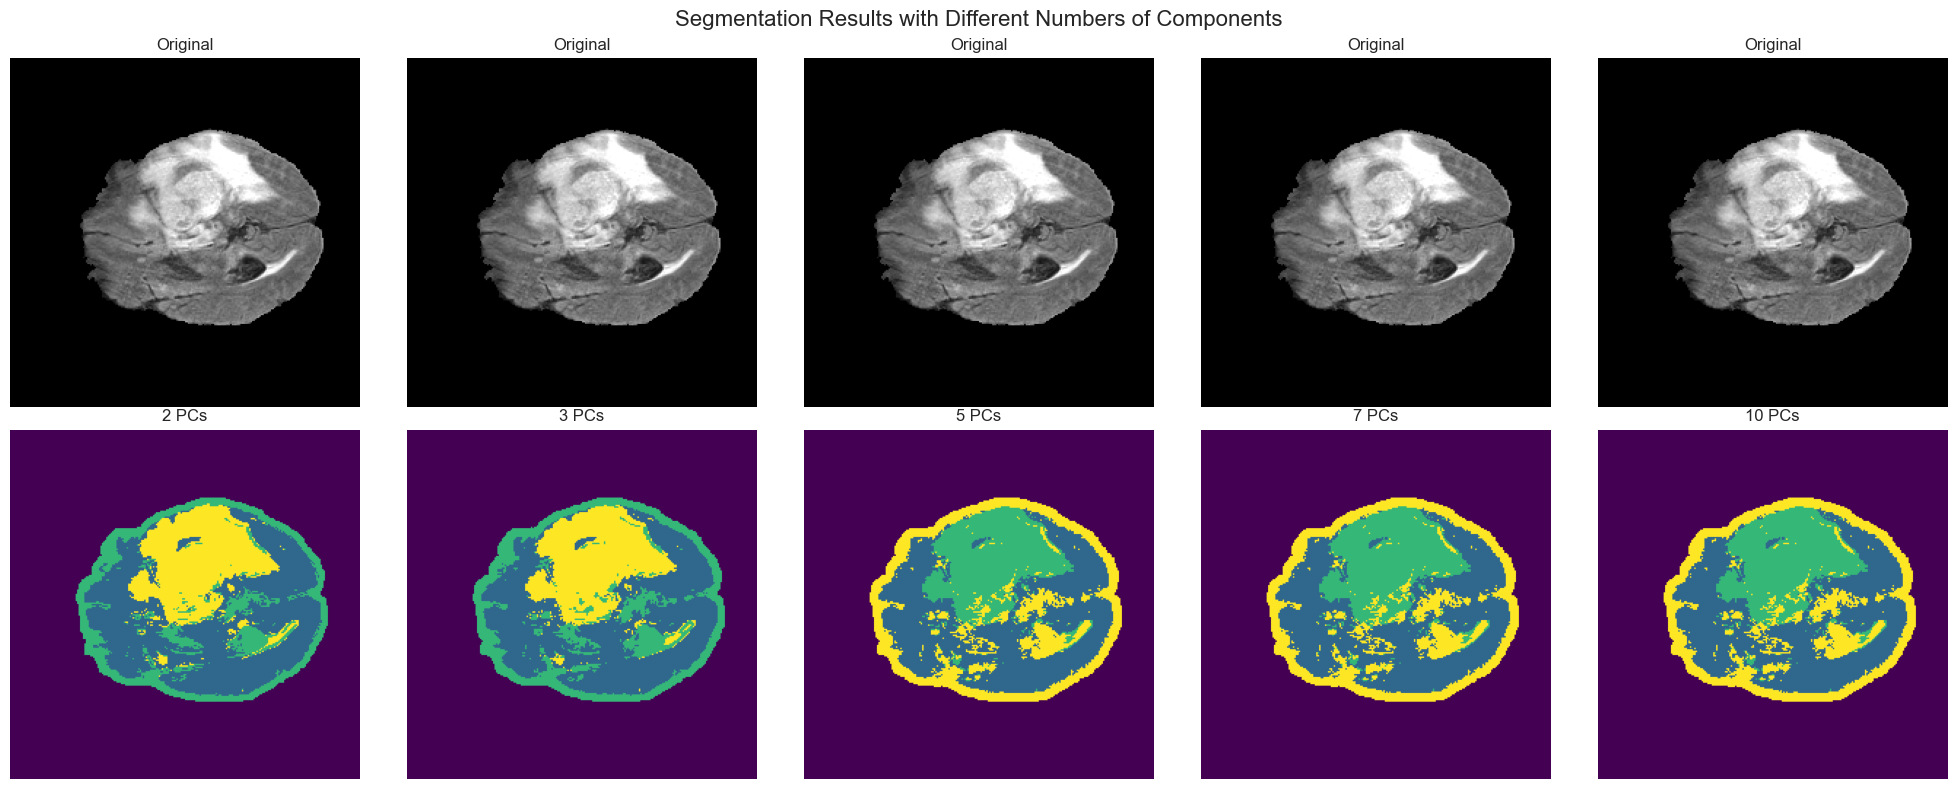

In [ ]:
# Test different numbers of components
component_counts = [2, 3, 5, 7, 10]
results_by_n_components = {}

for n_comp in component_counts:
    print(f"\nTesting with {n_comp} components...")
    pipe = SegmentationPipeline(n_components=n_comp, n_clusters=n_clusters)
    res = pipe.run_pipeline(image)
    results_by_n_components[n_comp] = res

# Visualize results
fig, axes = plt.subplots(2, len(component_counts), figsize=(20, 8))

for i, n_comp in enumerate(component_counts):
    res = results_by_n_components[n_comp]
    
    axes[0, i].imshow(image, cmap='gray')
    axes[0, i].set_title(f'Original')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(res['segmentation'], cmap='viridis')
    axes[1, i].set_title(f'{n_comp} PCs')
    axes[1, i].axis('off')

plt.suptitle('Segmentation Results with Different Numbers of Components', fontsize=16)
plt.tight_layout()
plt.savefig('../results/figures/n_components_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Discussion

### Key Findings:
1. **PCA Effectiveness**: PCA captures key variance in multi-modal MRI data for brain tumor identification
2. **Computational Efficiency**: Clustering in reduced eigenspace is computationally efficient compared to full-dimensional space
3. **Segmentation Quality**: PCA-based segmentation can identify tumor regions, though may require post-processing for clinical accuracy
4. **Eigenvector Interpretation**: Principal components correspond to meaningful features distinguishing tumor, edema, and healthy tissue

### Relationship between Eigenvalues/Eigenvectors and Image Features:
- **Largest eigenvalues** capture the most variance in tumor-tissue contrast across modalities
- **Eigenvectors** represent directions combining different MRI modalities optimally
- **First few PCs** often capture intensity differences between tumor regions and healthy tissue
- **Higher PCs** may capture fine details, edema boundaries, or imaging artifacts

### BraTS2020 Specific Observations:
- **Multi-modal integration**: Combining T1, T2, and FLAIR provides complementary information
- **Tumor heterogeneity**: Different tumor sub-regions (necrosis, edema, enhancing) show distinct patterns in PC space
- **Clinical relevance**: Unsupervised PCA+clustering can identify tumor regions without training data

## 11. Save Results

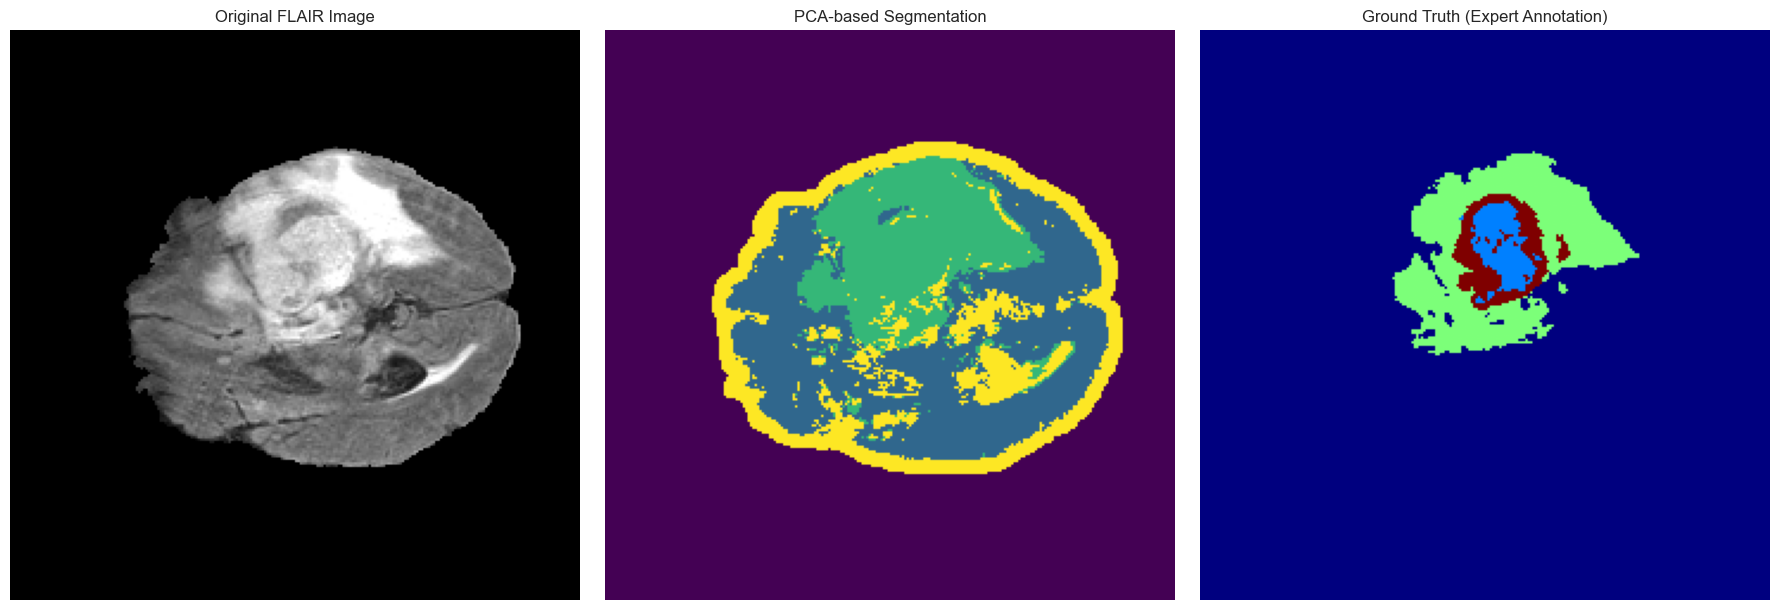


=== Comparison with Ground Truth ===
Accuracy: 0.7599
Jaccard Index (IoU): 0.2674
Dice Score: 0.4220

Note: These metrics compare binary tumor detection (tumor vs background)
Multi-class segmentation would require more sophisticated evaluation.


In [ ]:
if USE_BRATS and ground_truth is not None:
    # Visualize comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original FLAIR Image')
    axes[0].axis('off')
    
    axes[1].imshow(results['segmentation'], cmap='viridis')
    axes[1].set_title('PCA-based Segmentation')
    axes[1].axis('off')
    
    axes[2].imshow(ground_truth, cmap='jet', vmin=0, vmax=4)
    axes[2].set_title('Ground Truth (Expert Annotation)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('../results/figures/brats_comparison_ground_truth.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Compute overlap metrics
    from sklearn.metrics import confusion_matrix
    
    # Binarize: tumor vs background
    pred_binary = (results['segmentation'] > 0).astype(int)
    gt_binary = (ground_truth > 0).astype(int)
    
    # Compute metrics
    from sklearn.metrics import jaccard_score, f1_score, accuracy_score
    
    accuracy = accuracy_score(gt_binary.flatten(), pred_binary.flatten())
    jaccard = jaccard_score(gt_binary.flatten(), pred_binary.flatten(), average='binary')
    dice = f1_score(gt_binary.flatten(), pred_binary.flatten(), average='binary')
    
    print("\n=== Comparison with Ground Truth ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Jaccard Index (IoU): {jaccard:.4f}")
    print(f"Dice Score: {dice:.4f}")
    print("\nNote: These metrics compare binary tumor detection (tumor vs background)")
    print("Multi-class segmentation would require more sophisticated evaluation.")
else:
    print("Ground truth not available or not using BraTS data")

## 10.5. Compare with Ground Truth (BraTS2020 only)

For BraTS2020 data, compare segmentation results with expert-annotated ground truth.

In [ ]:
# Save segmentation results
np.save('../results/segmentations/segmentation_pca.npy', results['segmentation'])
np.save('../results/segmentations/segmentation_original.npy', seg_original)

# Save statistics
stats_df.to_csv('../results/tissue_statistics.csv')

print("Results saved to ../results/")

Results saved to ../results/
